From [kaggle.com](https://www.kaggle.com/gkoundry/bayesian-logistic-regression-with-pystan?).

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystan
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv')                                                            
train.pop('id')                                                                                      
target = train.pop('target').astype(int)

In [3]:
print(train.shape)
train.head()

(250, 300)


0      1      2      3      4      5      6      7      8      9  ...  \
0 -1.067 -1.114 -0.616  0.376  1.090  0.467 -0.422  0.460 -0.443 -0.338  ...   
1 -0.831  0.271  1.716  1.096  1.731 -0.197  1.904 -0.265  0.557  1.202  ...   
2  0.099  1.390 -0.732 -1.065  0.005 -0.081 -1.450  0.317 -0.624 -0.017  ...   
3 -0.989 -0.916 -1.343  0.145  0.543  0.636  1.127  0.189 -0.118 -0.638  ...   
4  0.811 -1.509  0.522 -0.360 -0.220 -0.959  0.334 -0.566 -0.656 -0.499  ...   

     290    291    292    293    294    295    296    297    298    299  
0  0.220 -0.339  0.254 -0.179  0.352  0.125  0.347  0.436  0.958 -0.824  
1 -0.765 -0.735 -1.158  2.554  0.856 -1.506  0.462 -0.029 -1.932 -0.343  
2 -1.311  0.799 -1.001  1.544  0.575 -0.309 -0.339 -0.148 -0.646  0.725  
3 -1.370  1.093  0.596 -0.589 -0.649 -0.163 -0.958 -1.081  0.805  3.401  
4 -0.178  0.718 -1.017  1.249 -0.596 -0.445  1.751  1.442 -0.393 -0.643  

[5 rows x 300 columns]

In [4]:
test = pd.read_csv('test.csv')
ids = test.pop('id') 

In [5]:
print(test.shape)
test.head()

(19750, 300)


0      1      2      3      4      5      6      7      8      9  ...  \
0 -0.677  1.721 -0.745 -0.838  0.149 -1.138  0.242  0.504 -1.829 -1.380  ...   
1 -0.731 -0.251  0.059  0.054  1.149  2.462  0.836  0.719 -2.269  0.584  ...   
2  1.119  1.036  1.220  1.518  0.265 -0.088  0.245 -0.533 -0.921  0.714  ...   
3 -0.933  0.212 -0.053  0.570 -1.540 -1.108  0.462  1.022 -0.215 -0.205  ...   
4 -0.208 -0.556  2.641  0.853 -0.384  0.312  0.514  0.481 -1.929 -0.400  ...   

     290    291    292    293    294    295    296    297    298    299  
0 -1.180 -0.403  0.759 -0.600  0.951 -0.349  0.446 -0.819 -0.277  1.297  
1  1.297  1.114  0.657  0.760  0.899 -1.612 -1.701  1.107 -0.314 -0.641  
2 -0.864 -0.736  0.367  0.154  0.830 -1.352  0.914  0.377  0.588 -0.912  
3  0.063 -0.958  0.762 -0.213 -2.171  0.830  1.435  0.125  2.782  0.619  
4 -0.689  0.213  0.568 -0.935 -0.015  0.267  0.739  1.340 -0.178  1.010  

[5 rows x 300 columns]

In [7]:
data = {                                                                                             
    'N': 250,                                                                                        
    'N2': 19750,                                                                                     
    'K': 300,                                                                                        
    'y': target,                                                                                     
    'X': train,                                                                                      
    'new_X': test,                                                                                   
}                                                                                                    

In [8]:
code = """                                                                                         
data {                                                                                               
  int N; //the number of training observations                                                       
  int N2; //the number of test observations                                                          
  int K; //the number of features                                                                    
  int y[N]; //the response                                                                           
  matrix[N,K] X; //the model matrix                                                                  
  matrix[N2,K] new_X; //the matrix for the predicted values                                          
}                                                                                                    
parameters {                                                                                         
  real alpha;                                                                                        
  vector[K] beta; //the regression parameters                                                        
}                                                                                                    
transformed parameters {                                                                             
  vector[N] linpred;                                                                                 
  linpred = alpha+X*beta;                                                                            
}                                                                                                    
model {                                                                                              
  alpha ~ cauchy(0,10); //prior for the intercept following Gelman 2008                              
                                                                                                     
  for(i in 1:K)                                                                                      
    beta[i] ~ student_t(1, 0, 0.03);                                                                 
                                                                                                     
  y ~ bernoulli_logit(linpred);                                                                      
}                                                                                                    
generated quantities {                                                                               
  vector[N2] y_pred;                                                                                 
  y_pred = alpha+new_X*beta; //the y values predicted by the model                                   
}                                                                                                    
"""               

In [9]:
sm = pystan.StanModel(model_code=code, verbose=True, )

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eb6ad662eabb07ff1dd484019461995e NOW.
INFO:pystan:OS: win32, Python: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)], Cython 0.29.23


Compiling C:\Users\camin\AppData\Local\Temp\pystan__yj7l6im\stanfit4anon_model_eb6ad662eabb07ff1dd484019461995e_3743848480003101320.pyx because it changed.
[1/1] Cythonizing C:\Users\camin\AppData\Local\Temp\pystan__yj7l6im\stanfit4anon_model_eb6ad662eabb07ff1dd484019461995e_3743848480003101320.pyx
INFO: No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
building 'stanfit4anon_model_eb6ad662eabb07ff1dd484019461995e_3743848480003101320' extension
creating C:\Users\camin\AppData\Local\Temp\pystan__yj7l6im\Users
creating C:\Users\camin\AppData\Local\Temp\pystan__yj7l6im\Users\camin
creating C:\Users\camin\AppData\Local\Temp\pystan__yj7l6im\Users\camin\AppData
creating C:\Users\camin\AppData\Local\Temp\pystan__yj7l6im\Users\camin\AppData\Local
creating C:\Users\camin\AppData\Local\Temp\pystan__yj7l6im\Users\camin\AppData\Local\Temp
creating C:\Users\camin\AppData\Local\Temp\pystan__yj7l6im\Users\camin\AppData\Local\Temp\pystan__yj7l6im
INFO: C:\Progra

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa2 in position 429: invalid start byte

In [9]:
fit = sm.sampling(data=data, seed=101, verbose=True, n_jobs=2)
# Changed seed, set n_jobs to 2.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [10]:
ex = fit.extract(permuted=True)

In [11]:
print(fit)

Inference for Stan model: anon_model_eb6ad662eabb07ff1dd484019461995e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%     25%     50%     75%   97.5%  n_eff   Rhat
alpha            -1.89    0.01   0.34  -2.62    -2.1   -1.88   -1.65   -1.27   1037   1.01
beta[1]          -0.01  1.7e-3   0.08   -0.2   -0.03 -3.5e-3    0.02    0.12   2164    1.0
beta[2]          -0.08  6.3e-3   0.17   -0.6   -0.09   -0.02  6.7e-3    0.08    722    1.0
beta[3]          -0.04  3.3e-3   0.12   -0.4   -0.06   -0.01    0.01     0.1   1236    1.0
beta[4]           0.07  5.0e-3   0.16  -0.09 -9.8e-3    0.02    0.08    0.56   1021    1.0
beta[5]           0.02  2.3e-3   0.09  -0.12   -0.02  7.3e-3    0.04    0.28   1707    1.0
beta[6]           0.02  1.3e-3   0.08  -0.12   -0.02  6.4e-3    0.04    0.21   3339    1.0
beta[7]           0.05  3.3e-3   0.12  -0.08   -0.01    0.01    0.06    0.42   1225

In [12]:
print(fit.stansummary())

Inference for Stan model: anon_model_eb6ad662eabb07ff1dd484019461995e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%     25%     50%     75%   97.5%  n_eff   Rhat
alpha            -1.89    0.01   0.34  -2.62    -2.1   -1.88   -1.65   -1.27   1037   1.01
beta[1]          -0.01  1.7e-3   0.08   -0.2   -0.03 -3.5e-3    0.02    0.12   2164    1.0
beta[2]          -0.08  6.3e-3   0.17   -0.6   -0.09   -0.02  6.7e-3    0.08    722    1.0
beta[3]          -0.04  3.3e-3   0.12   -0.4   -0.06   -0.01    0.01     0.1   1236    1.0
beta[4]           0.07  5.0e-3   0.16  -0.09 -9.8e-3    0.02    0.08    0.56   1021    1.0
beta[5]           0.02  2.3e-3   0.09  -0.12   -0.02  7.3e-3    0.04    0.28   1707    1.0
beta[6]           0.02  1.3e-3   0.08  -0.12   -0.02  6.4e-3    0.04    0.21   3339    1.0
beta[7]           0.05  3.3e-3   0.12  -0.08   -0.01    0.01    0.06    0.42   1225

/usr/local/lib/python3.7/site-packages/arviz/plots/traceplot.py:254: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (20301), generating only 20 plots
  UserWarning,


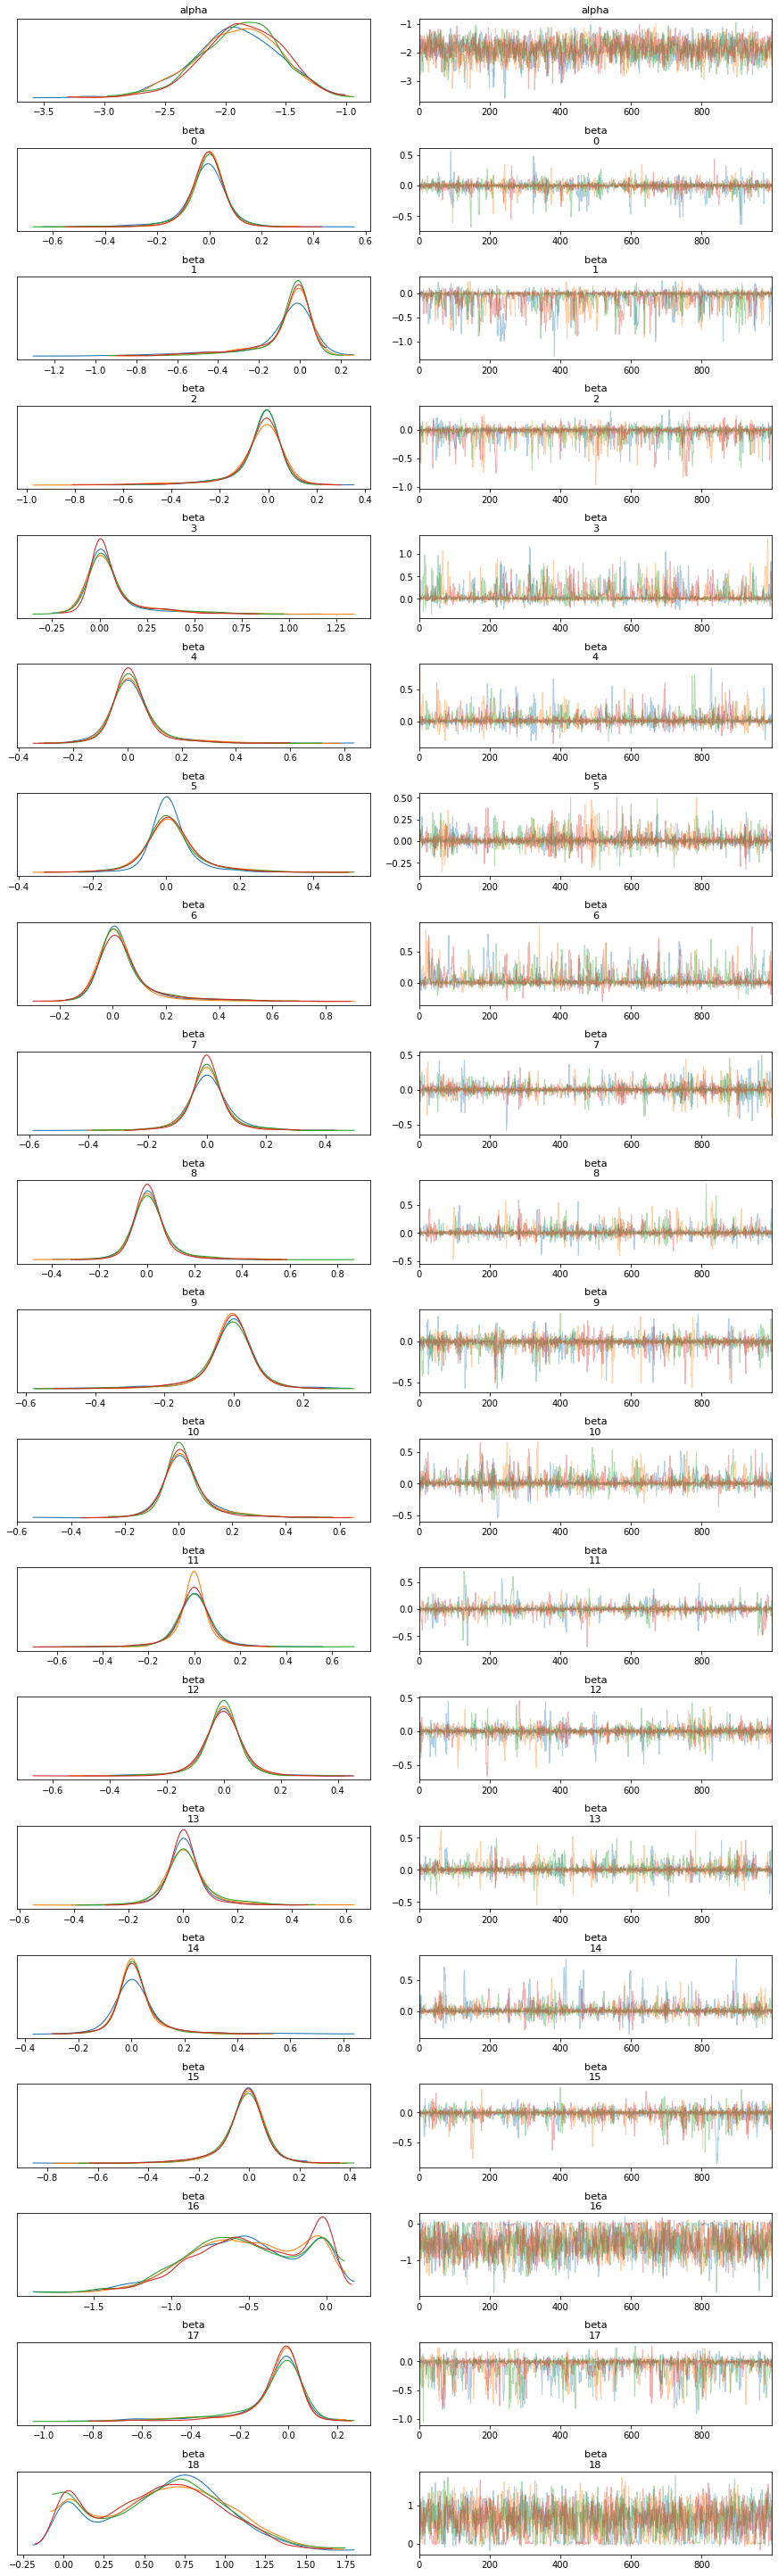

In [13]:
az.plot_trace(fit);

In [14]:
target = np.mean(ex['y_pred'], axis=0)                                                               

In [15]:
df = pd.DataFrame({'id': ids, 'target': target})

In [16]:
print(df.shape)
df.head()

(19750, 2)


id    target
0  250  0.128289
1  251 -2.074227
2  252 -1.367759
3  253  0.011535
4  254  0.315070

In [20]:
post_data = az.convert_to_dataset(fit)

In [23]:
def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  # Summary statistics
  mean = np.mean(param)
  median = np.median(param)
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
  
  # Plotting
  plt.subplot(2,1,1)
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='r', lw=2, linestyle='--')
  plt.axhline(median, color='c', lw=2, linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
  plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
  plt.title('Trace and Posterior Distribution for {}'.format(param_name))

  plt.subplot(2,1,2)
  plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
  plt.gcf().tight_layout()
  plt.legend()

In [24]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

df.head()

mean   se_mean        sd      2.5%       25%       50%       75%  \
alpha   -1.892016  0.010634  0.342526 -2.616695 -2.103329 -1.878331 -1.654001   
beta[1] -0.011344  0.001700  0.079074 -0.198298 -0.031551 -0.003532  0.020224   
beta[2] -0.080648  0.006280  0.168791 -0.602597 -0.093378 -0.021412  0.006700   
beta[3] -0.041818  0.003315  0.116543 -0.402283 -0.057251 -0.012648  0.012915   
beta[4]  0.069279  0.004974  0.158901 -0.088581 -0.009811  0.017355  0.077251   

            97.5%        n_eff      Rhat  
alpha   -1.273594  1037.466126  1.006313  
beta[1]  0.121521  2163.642413  1.002520  
beta[2]  0.078669   722.285456  1.004980  
beta[3]  0.097489  1236.291793  1.000578  
beta[4]  0.561916  1020.589734  1.003091

In [26]:
# Extracting traces
alpha = fit['alpha']
beta1 = fit['beta[1]']
beta2 = fit['beta[2]']
beta3 = fit['beta[3]']
beta4 = fit['beta[4]']

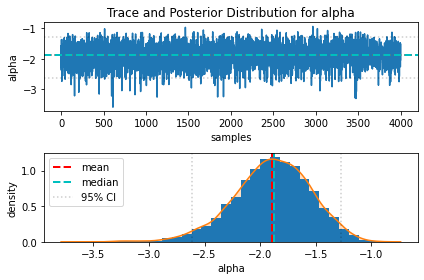

In [29]:
plot_trace(alpha, 'alpha') 

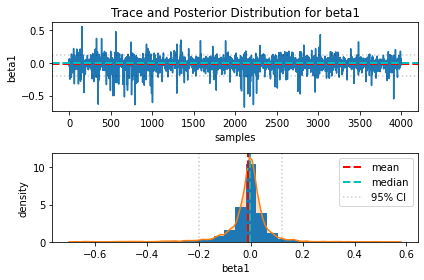

In [31]:
plot_trace(beta1, 'beta1') 

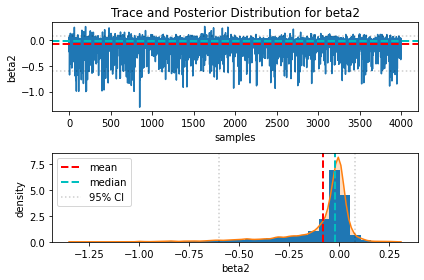

In [32]:
plot_trace(beta2, 'beta2') 

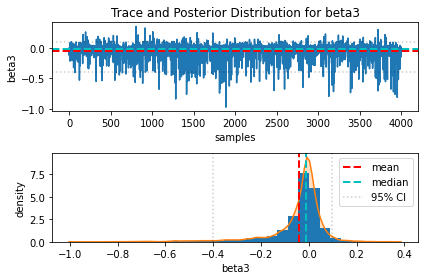

In [33]:
plot_trace(beta3, 'beta3') 

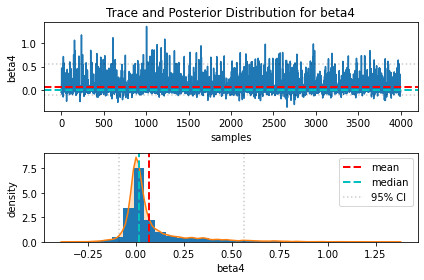

In [34]:
plot_trace(beta4, 'beta4') 

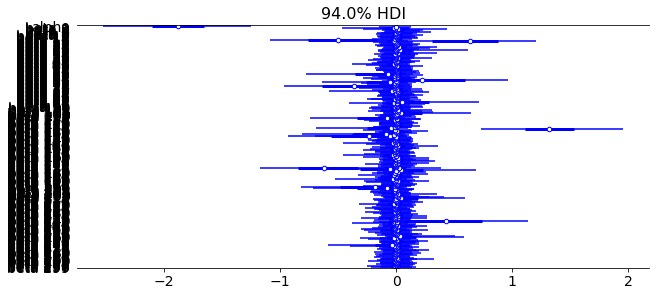

In [37]:
# Let's examine the posterior distribution of our model parameters
axes = az.plot_forest(
    post_data,
    kind="forestplot",
    var_names= ["alpha","beta"],
    combined=True,
    ridgeplot_overlap=1.5,
    colors="blue",
    figsize=(9, 4),
)